# Deep Reinforcement Learning Navigation Project
This notebook contains my solution for the navigation project. A UnityEnvironment [1] in which an agent should learn to collect yellow bananas, while avoiding blue banans, was provided by Udacity.

The agent uses the DQN network (Mnith et al., 2015, [2]) and two improvements, namely Double-DQN (van Hasselt et al., 2015, [3]) and Dueling Network Architectures ( Wang et al., 2015, [4]).

I emphasized simplicty in the implementation of replay memory and agent over the most efficient or most expandability. Before writing my implementation I studied the DQN example from the Udacity Deep Reinforcement Learning Repository [5], the instructions for the navigation project [6] and the DQN implementation from OpenAi Baselines [7]. Additionally, the PyTorch documentation & tutorial page was very helpful to get started on PyTorch.

## Learning algorithm

The agent uses the DQN algorithm by Mnith et al. (2015, [2]), in which a neural network is used in order to learn the Q-values of an environment. 
At time $t$, the agent is in state $s_t$ and chooses an action $a_t$ with an $\epsilon$ greedy policy and observes the response of the environment (especially the reward $r_{t+1}$ and the next state $s_{t+1}$).
The tuple ($s_t$, $a_t$, $r_{t+1}$, $s_{t+1}$) forms on element of experience and is saved in the Replay Memory.
When enough experience is collected, the agent samples from the Replay Memory randomly and uses this vector of experience for a batch update of the q networks.
To update the network, we try to minimize the loss [2]:
$$ L = r_{t+1} + \gamma * max_{a} Q(s_{t+1}, a, \theta') - Q(s_{t}, a_{t}, \theta ) $$,
where $\theta$ is the Q-network and $\theta'$ is the target network. The target network is updated to be a copy of the q-network after n steps. 

The Double-DQN algorithm [3] sightly modifies the learning step for the q-network in order to obtain a more stable update. In the dueling network method [4], the neural network used to obtain the Q-values is split in one part representing the value of a state and the so-called "advantage", which represents the additional value coming from choosing a particular action.


In [2]:
# Import the necessary libraries
from collections import deque, namedtuple
from random import sample
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from unityagents import UnityEnvironment

# Settings

# Paths and folders:

environment_path = "/data/Banana_Linux_NoVis/Banana.x86_64"
model_save_path = "./data/"

# Select the different versions of the agent that you want to train
Setting = namedtuple("Settings",'name, lr, ddqn, duel')
test_settings = []
test_settings.append(Setting("DQN", 5e-4, False, False))   # Plain DQN
test_settings.append(Setting("DDQN", 5e-4, True, False))    # DDQN
test_settings.append(Setting("DDQN + Duel", 5e-4, True, True))     # DDQN + Duel Network

# maximal number of episodes each agent is trained on
number_episodes = 1000
# Choose if your calculations are performed on a GPU or on the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Experience = namedtuple('Experience','state action reward next_state done')

## Neural networks
The dqn class is used to implement the neural network for the standard DQN algorithm as well as the dueling network algorithm. You can select the dueling network with the duel flag in the constructor.

The standard DQN model has three fully-connected hidden layers with 64 neurons each and four outputs, one output for each possible action. After the first two hidden layers a ReLU is used as the activation function.

The dueling network uses two layers with 64 neurons in the beginning, afterwards the network is split and one part for the state value and one part for the advantage. The state value part has one layer with 64 neurons and a second layer with 48 neurons. The advantage part uses slightly more neurons (64 in the first and 64 in the second layer), since it ultimately also has more outputs.

In [3]:
class dqn(nn.Module):
    def __init__(self, state_size, action_size, duel = False):
        super(dqn, self).__init__()
        self.duel = duel
        self.fc1 = nn.Linear( state_size, 64 )
        self.fc2 = nn.Linear( 64, 64 )
        self.fc3 = nn.Linear( 64, action_size )
        
        self.fc3v = nn.Linear( 64, 48)
        self.fc4v = nn.Linear( 48, 1 )
        self.fc3a = nn.Linear( 64, 64)
        self.fc4a = nn.Linear( 64, action_size )
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        
        if not self.duel:
            x = self.fc3(x)               # The regular case
        else:
            v = F.relu(self.fc3v( x ))    # The duel network architecture
            v = self.fc4v( v )
            a = F.relu(self.fc3a( x ))
            a = self.fc4a( a )
            x = v + (a - a.mean())        # Subtract a.mean(), another choice would be a.max()
        return x

The Replay Memory is used to save and sample experience. The deque can only cold maxLen elements, thus older elements are deleted from Replay Memory. 

In [4]:
class ReplayMemory():
    def __init__(self, maxLen ):
        self.data = deque(maxlen=maxLen)
        return
    def add(self, sample):
        self.data.append(sample)
        return
    def sample(self, number_samples):
        length = len(self.data)
        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []
        if(length > number_samples):
            elements = list(range(length))
            indices = sample(elements, number_samples)
            for index in indices:
                state, action, reward, next_state, done = self.data[index]
                states.append(state)
                actions.append(action)
                rewards.append(reward)
                next_states.append(next_state)
                dones.append(done)
        states_d = torch.from_numpy(np.array(states)).float().unsqueeze(1).to(device)
        actions_d = torch.from_numpy(np.array(actions)).long().unsqueeze(1).to(device)
        rewards_d = torch.from_numpy(np.array(rewards)).float().unsqueeze(1).to(device)
        next_states_d = torch.from_numpy(np.array(next_states)).float().to(device)
        dones_d = torch.from_numpy(np.array(dones).astype(np.float32)).float().unsqueeze(1).to(device)

        # Returning experience vectors, similar to the DQN network solution from [5]
        return tuple((states_d, actions_d, rewards_d, next_states_d, dones_d))

Below is the implementation of the agent, there are various hyperparameters that can be set.
The parameters are explained in the comments of the __init__ method.

In [5]:
   class Agent():
    def __init__(self, state_size, action_size, settings, maxLen = 10000):
        
        # Create the replay memory and the two neural networks and the optimizer function
        self.mem = ReplayMemory(maxLen)
        self.q_net = dqn(state_size, action_size).to(device)
        self.tgt_net = dqn(state_size, action_size).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr = settings.lr)
        
        # Set some constants and hyperparameters for the agent
        self.duel = settings.duel                 # Using duel network architecture or not
        self.ddqn = settings.ddqn                 # Using the DDQN update step instead of DQN
        self.epsilon_start = 1                    # Epsilon governs the amount of exploration in the action selection step
        self.epsilon_decay_rate = 1.0/100000.0    # Epsilon should decay in order to have more exploitation later in training.
        self.epsilon_min = 0.01                   # The decay is governed by the epsilon_decay_rate and epsilon_min
        self.update_every = 4                     # Update the q-network after update_every steps
        self.copy_net_every = 1000                # How often is tgt_net updated
        self.batch_size = 64                      # Size of the batch used for training
        self.gamma = 0.99                         # Decay rate for future updates

        #reset some variables
        self.count = 0
        self.epsilon = self.epsilon_start

    def update(self, sample):
        self.count += 1
        self.epsilon = max(self.epsilon - self.epsilon, self.epsilon_min)
        self.mem.add(sample)
        
        if self.count%self.copy_net_every == 0:
            self.tgt_net.load_state_dict(self.q_net.state_dict())
        if self.count > self.batch_size and self.count%self.update_every == 0:
            states, actions, rewards, next_states, dones = self.mem.sample(self.batch_size)
            
            if not self.ddqn:
                q_target = rewards + self.gamma * (1.0 - dones) * self.tgt_net(next_states).max(1)[0].unsqueeze(1)
            else:
                next_action = self.q_net(next_states).max(1)[1].unsqueeze(1)
                next_q = self.tgt_net(next_states).squeeze(1).gather(1, next_action)
                q_target = rewards + self.gamma * (1.0 - dones) * next_q

            q_target = q_target.detach()
            q_prediction = self.q_net(states).squeeze(1)
            q_prediction = q_prediction.gather(1, actions)
            loss = F.mse_loss(q_target, q_prediction)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return
    
    def get_action(self, state):
        if(np.random.rand() < self.epsilon):
            return np.argmax(np.random.rand(4))
        else:
            state = torch.from_numpy(state).float().to(device)
            qvals = self.q_net(state).cpu().data.numpy()
            return np.argmax(qvals)
    def save_nns(self, path):
        q_net_path = model_save_path + str(setting) + "_q_net.pt"
        torch.save(self.q_net.state_dict(), q_net_path)
        tgt_net_path = model_save_path + str(setting) + "_tgt_net.pt"
        torch.save(self.tgt_net.state_dict(), tgt_net_path)
        return

In [6]:
# Loading environments & setting brain, as in Navigation.ipynb from [6]:
env = UnityEnvironment(file_name=environment_path)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0] 

action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)
#

result_collector = []
for i, setting in enumerate(test_settings):
    
    print("Setting")
    # construct the agent
    agent = Agent(state_size, action_size, setting)

    # reset the lists for monitoring progress
    all_rewards = []
    avg_rewards = []
    last_rewards = deque(maxlen = 100)
    
    # start training
    for n in range(number_episodes):
        sum_reward = 0
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0] 
        while True:
            action = agent.get_action(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            experience = Experience(state, action, reward, next_state, done)
            agent.update(experience)
            sum_reward += reward     
            state = next_state                             
            if done:                                       
                break
        all_rewards.append(sum_reward)
        last_rewards.append(sum_reward)
        avg = np.mean(last_rewards)
        avg_rewards.append(avg)
        if( avg > 15 or n == number_episodes - 1):
            print("Problem solved after " + str(n) + " episodes, average reward: " + str(avg))
            result_collector.append(avg_rewards)
            env.reset(train_mode=True)[brain_name]
            agent.save_nns(model_save_path)
            break
        if n%5 == 0:
            print("Playing episode " + str(n) + " reward: " + str(np.mean(sum_reward)) + " average reward: " + str(np.mean(last_rewards)))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Setting
Playing episode 0 reward: 0.0 average reward: 0.0
Playing episode 5 reward: 1.0 average reward: 0.666666666667
Playing episode 10 reward: 0.0 average reward: 0.363636363636
Playing episode 15 reward: 1.0 average reward: 0.25
Playing episode 20 reward: 3.0 average reward: 0.571428571429
Playing episode 25 reward: -2.0 average reward: 0.730769230769
Playing episode 30 reward: 4.0 average reward: 0.967741935484
Playing episode 35 reward: 0.0 average reward: 1.22222222222
Playing episode 40 reward: 4.0 average reward: 1.78048780488
Playing episode 45 reward: 4.0 average reward: 2.30434782609
Playing episode 50 reward: 6.0 average reward: 2.80392156863
Playing episode 55 reward: 10.0 average reward: 3.21428571429
Playing episode 60 reward: 15.0 average reward: 3.91803278689
Playing episode 65 reward: 14.0 average reward: 4.51515151515
Playing episode 70 reward: 9.0 average reward: 4.88732394366
Playing episode 75 reward: 15.0 average reward: 5.26315789474
Playing episode 80 reward: 

## Results
While the original goal was to have an agent that achieves an average score above 13 in 100 consecutives episodes.  However, since all three agents achieve this goal rather quickly, I set up the goal to 15 in order to see what performance the agents obtain in the longrun. Below is a figure of the average rewards for each of the three different methods.

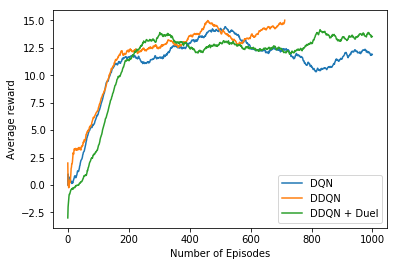

In [8]:
import matplotlib.pyplot as plt

labels = [setting.name for setting in test_settings]
for name, result in zip(labels, result_collector):
    plt.plot(result, label = name)
plt.xlabel('Number of Episodes')
plt.ylabel('Average reward')
plt.legend()
plt.show()

## Discussion
![figure.png](attachment:figure.png)
The figure above shows a result form an earlier run. The DDQN network seems to converge to a good solution quicker than the two other methods and has lower variance after reaching the plateau. One possible explanation for the bad performance of the DDQN + Duel method might be that the layout of the neural network is not ideal for this task. Additionally, the "Rainbow " manuscript by Hessel et al. (2017, [8]), who compared the performance of various DQN methods on 57 diffrent Atari games, showed that not all improvements lead to a better performance on each individual task. 

For the future implementing the different improvements from [8] into the agent would be an interesting direction. For example, Prioritized Experience Replay [9] focuses on using updates that are good candidates to improve the TD-error rather than randomly sampling updates from the replay memory. However, even without further improvements the performance is already quite good on this task.

# References

[1] Juliani, A., Berges, V., Vckay, E., Gao, Y., Henry, H., Mattar, M., Lange, D. (2018). Unity: A General Platform for Intelligent Agents. arXiv preprint arXiv:1809.02627. https://github.com/Unity-Technologies/ml-agents.

[2] Mnih, Volodymyr, et al. "Human-level control through deep reinforcement learning." Nature 518.7540 (2015): 529.

[3] van Hasselt, Hado, Arthur Guez, and David Silver. "Deep Reinforcement Learning with Double Q-learning." arXiv preprint arXiv:1509.06461v3 (2015).

[4] Wang, Ziyu, et al. "Dueling network architectures for deep reinforcement learning." arXiv preprint arXiv:1511.06581v3 (2015).

[5] https://github.com/udacity/deep-reinforcement-learning, last accessed: 10.03.2019

[6] https://github.com/udacity/deep-reinforcement-learning/tree/master/p1_navigation, last accessed: 10.03.2019

[7] https://github.com/openai/baselines, last accessed: 10.03.2019

[8] https://pytorch.org/tutorials/, last accessed: 10.03.2019

[9] Hessel, Matteo, et al. "Rainbow: Combining Improvements in Deep Reinforcement Learning." arXiv preprint arXiv:1710.02298 (2017).

[10] Schaul, Tom, et al. "Prioritized experience replay." arXiv preprint arXiv:1511.05952 (2015).